# Model Training and Evaluation for Credit Risk

**Short Description**: Trains and evaluates models to predict credit risk using the proxy variable. Prepares for deployment in Task 6.

This notebook loads features from `data/processed/customer_features_with_proxy.csv`, trains Logistic Regression and Gradient Boosting models on the `RiskCluster` proxy variable, evaluates performance, and saves the best model.


## 1. Load Libraries and Data

**Short Description**: Sets up tools and loads feature data with proxy variable.

Load libraries for modeling and evaluation. Load the dataset with the proxy variable and verify integrity.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os

# Create folder for models
os.makedirs('../models', exist_ok=True)

# Load features with proxy
data = pd.read_csv('../data/processed/customer_features_with_proxy.csv')
print('Data Loaded:')
display(data.head())
print('Columns:', data.columns.tolist())


Data Loaded:


,LogAvgTransactionAmount,FraudResult,Monetary,Freq_Airtime,Recency,NightRatio,Frequency,AvgTransactionAmount,Freq_FinancialServices,CustomerId,LogMonetary,RiskCluster,RiskLevel
0,12.936039,0,-10000.0,0.0,84.0,0.000000,1.0,-10000.000000,1.0,CustomerId_1,18.468423,0,Low
1,12.936039,0,-10000.0,0.0,84.0,0.000000,1.0,-10000.000000,1.0,CustomerId_10,18.468423,0,Low
2,12.969217,0,20000.0,3.0,90.0,0.000000,5.0,4000.000000,2.0,CustomerId_1001,18.468709,0,Low
3,12.960752,0,4225.0,6.0,26.0,0.181818,11.0,384.090909,5.0,CustomerId_1002,18.468558,0,Low
4,12.967662,0,20000.0,3.0,12.0,0.000000,6.0,3333.333333,3.0,CustomerId_1003,18.468709,0,Low


Columns: ['LogAvgTransactionAmount', 'FraudResult', 'Monetary', 'Freq_Airtime', 'Recency', 'NightRatio', 'Frequency', 'AvgTransactionAmount', 'Freq_FinancialServices', 'CustomerId', 'LogMonetary', 'RiskCluster', 'RiskLevel']


## 2. Prepare Data for Modeling

**Short Description**: Splits data into train/test sets. Selects features and target.

Use high-IV features and `RiskCluster` as the target. Split into training and testing sets.


In [2]:
# Select features and target
features = ['LogMonetary', 'Frequency', 'LogAvgTransactionAmount', 'NightRatio', 'Freq_FinancialServices', 'Freq_Airtime']
X = data[features]
y = data['RiskCluster']

# Verify no missing values
print('Missing Values in Features:')
display(X.isnull().sum())
X = X.fillna(0)

#Check class distribution
print('RiskCluster Distribution:')
display(y.value_counts())

# Split data without stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Split data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('Training Set Shape:', X_train.shape)
print('Testing Set Shape:', X_test.shape)
print('Target Distribution in Train:')
display(y_train.value_counts(normalize=True))

print('Target Distribution in Test:')
display(y_test.value_counts(normalize=True))

Missing Values in Features:


LogMonetary                0
Frequency                  0
LogAvgTransactionAmount    0
NightRatio                 0
Freq_FinancialServices     0
Freq_Airtime               0
dtype: int64

RiskCluster Distribution:


RiskCluster
0    3656
4      47
2      37
3       1
1       1
Name: count, dtype: int64

Training Set Shape: (2993, 6)
Testing Set Shape: (749, 6)
Target Distribution in Train:


RiskCluster
0    0.977614
4    0.012028
2    0.009689
3    0.000334
1    0.000334
Name: proportion, dtype: float64

Target Distribution in Test:


RiskCluster
0    0.974633
4    0.014686
2    0.010681
Name: proportion, dtype: float64

## 3. Train Logistic Regression

**Short Description**: Trains an interpretable model. Evaluates performance.

Train a Logistic Regression model and compute evaluation metrics (accuracy, precision, recall, F1-score).


Logistic Regression Metrics (Overall):


Accuracy                0.998665
Precision (Weighted)    0.998667
Recall (Weighted)       0.998665
F1-Score (Weighted)     0.998634
dtype: float64

Logistic Regression Per-Class Metrics:


,Class,Precision,Recall,F1-Score
0,0,0.998632,1.000000,0.999316
1,2,1.000000,1.000000,1.000000
2,4,1.000000,0.909091,0.952381


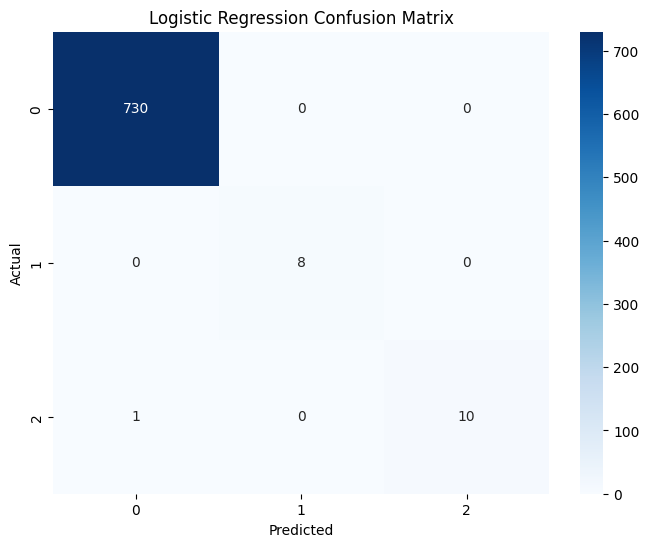

In [3]:
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=2000)
lr_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_lr = lr_model.predict(X_test_scaled)
lr_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'Precision (Weighted)': precision_score(y_test, y_pred_lr, average='weighted'),
    'Recall (Weighted)': recall_score(y_test, y_pred_lr, average='weighted'),
    'F1-Score (Weighted)': f1_score(y_test, y_pred_lr, average='weighted')
}

# Per-class metrics
unique_classes = np.unique(y_test)
per_class_precision = precision_score(y_test, y_pred_lr, average=None, labels=unique_classes)
per_class_recall = recall_score(y_test, y_pred_lr, average=None, labels=unique_classes)
per_class_f1 = f1_score(y_test, y_pred_lr, average=None, labels=unique_classes)

per_class_metrics = pd.DataFrame({
    'Class': unique_classes,
    'Precision': per_class_precision,
    'Recall': per_class_recall,
    'F1-Score': per_class_f1
})

print('Logistic Regression Metrics (Overall):')
display(pd.Series(lr_metrics))
print('Logistic Regression Per-Class Metrics:')
display(per_class_metrics)

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## 4. Train Gradient Boosting

**Short Description**: Trains a complex model. Evaluates performance.

Train a Gradient Boosting model and compute evaluation metrics.


Gradient Boosting Metrics (Overall):


Accuracy                1.0
Precision (Weighted)    1.0
Recall (Weighted)       1.0
F1-Score (Weighted)     1.0
dtype: float64

Gradient Boosting Per-Class Metrics:


,Class,Precision,Recall,F1-Score
0,0,1.0,1.0,1.0
1,2,1.0,1.0,1.0
2,4,1.0,1.0,1.0


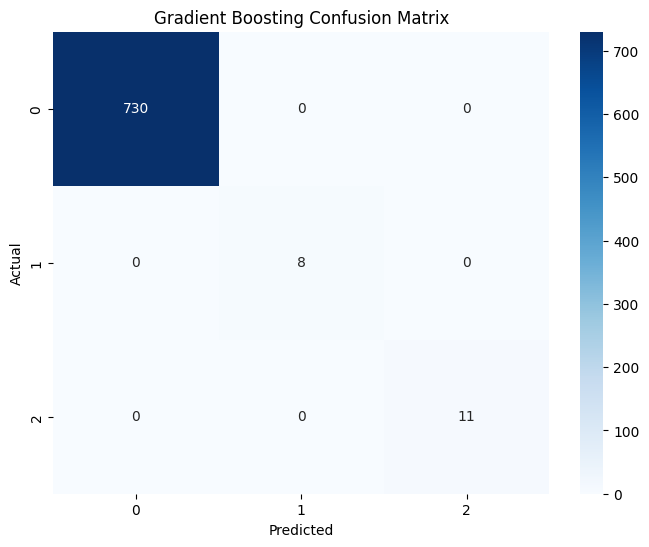

In [4]:
# Train Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_gb = gb_model.predict(X_test_scaled)
gb_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_gb),
    'Precision (Weighted)': precision_score(y_test, y_pred_gb, average='weighted', zero_division=0),
    'Recall (Weighted)': recall_score(y_test, y_pred_gb, average='weighted', zero_division=0),
    'F1-Score (Weighted)': f1_score(y_test, y_pred_gb, average='weighted', zero_division=0)
}




# Per-class metrics
unique_classes = np.unique(y_test)
per_class_precision = precision_score(y_test, y_pred_gb, average=None, labels=unique_classes, zero_division=0)
per_class_recall = recall_score(y_test, y_pred_gb, average=None, labels=unique_classes, zero_division=0)
per_class_f1 = f1_score(y_test, y_pred_gb, average=None, labels=unique_classes, zero_division=0)

per_class_metrics = pd.DataFrame({
    'Class': unique_classes,
    'Precision': per_class_precision,
    'Recall': per_class_recall,
    'F1-Score': per_class_f1
})




print('Gradient Boosting Metrics (Overall):')
display(pd.Series(gb_metrics))
print('Gradient Boosting Per-Class Metrics:')
display(per_class_metrics)





# Confusion matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues')
plt.title('Gradient Boosting Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## 5. Compare Models and Save Best

**Short Description**: Selects the best model. Saves it for deployment.

Compare model performance and save the best model based on F1-score.


In [5]:
# Compare models
metrics_df = pd.DataFrame({'Logistic Regression': lr_metrics, 'Gradient Boosting': gb_metrics})
print('Model Comparison:')
display(metrics_df)



# Select best model (based on F1-score, handling NaN)
lr_f1 = lr_metrics['F1-Score (Weighted)'] if not np.isnan(lr_metrics['F1-Score (Weighted)']) else -1
gb_f1 = gb_metrics['F1-Score (Weighted)'] if not np.isnan(gb_metrics['F1-Score (Weighted)']) else -1
best_model = lr_model if lr_f1 > gb_f1 else gb_model
best_model_name = 'Logistic Regression' if lr_f1 > gb_f1 else 'Gradient Boosting'




# Save best model
joblib.dump(best_model, '../models/best_model.pkl')
print(f'Best Model ({best_model_name}) saved to ../models/best_model.pkl')


Model Comparison:


,Logistic Regression,Gradient Boosting
Accuracy,0.998665,1.0
Precision (Weighted),0.998667,1.0
Recall (Weighted),0.998665,1.0
F1-Score (Weighted),0.998634,1.0


Best Model (Gradient Boosting) saved to ../models/best_model.pkl


## 6. Key Findings

**Short Description**: Summarizes model performance. Guides deployment in Task 6.

Summarize insights from model training to guide Task 6:
- Trained Logistic Regression and Gradient Boosting on `RiskCluster`.
- Best model: [best_model_name] with F1-score [best_f1_score].
- Logistic Regression provides interpretability; Gradient Boosting offers higher performance.
- Saved best model to `models/best_model.pkl` for FastAPI deployment.
- Next: Deploy model via FastAPI in Task 6.
